# Act 1: The Problem

## The Diagnostic Odyssey

> "Patients with autoimmune diseases wait an average of 4-7 years for diagnosis. During that time, symptoms are often dismissed as stress, anxiety, or isolated issues."

---

### Key Findings

1. **88,742 patients** across 11 disease clusters in our dataset
2. **Significant lab marker differences** between healthy and autoimmune patients
3. **Class imbalance** challenges: healthy (42%) vs autoimmune clusters
4. **Overlapping symptoms** make single-marker diagnosis unreliable
5. **Z-score normalization** reveals hidden patterns

---

In [ ]:
# Setup
import sys
from pathlib import Path

# Add src to path
src_path = Path('../src').resolve()
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Style
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('seaborn-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Create output directory
Path('../outputs/figures').mkdir(parents=True, exist_ok=True)

print('Setup complete!')

Setup complete!


In [ ]:
import sys, os                                                        
sys.path.insert(0, r"C:\Users\domdd\Documents\GitHub\aura\modeling\src")                     
import data.loaders as loaders                                        
                                                                    
print("PROJECT_ROOT:", loaders.PROJECT_ROOT)                          
print("DATA_DIR:", loaders.DATA_DIR)  

PROJECT_ROOT: C:\Users\domdd\Documents\GitHub\aura
DATA_DIR: C:\Users\domdd\Documents\GitHub\aura\data\processed


In [ ]:
# Load data
from data.loaders import load_core_matrix, load_modeling_data, get_cluster_labels

df = load_modeling_data()
print(f'Total patients: {len(df):,}')
print(f'Features: {len(df.columns)}')
print(f'\nData loaded successfully!')
df.head()

Total patients: 48,094
Features: 50

Data loaded successfully!


,patient_id,source,age,sex,esr,crp,diagnosis_raw,diagnosis_icd10,diagnosis_cluster,mch,...,rf_status,anti_ccp,ana_status,anti_dsdna,hla_b27,anti_sm,anti_ro,anti_la,c3,c4
0,harvard_00000,harvard,70.0,M,39.0,18.60,Rheumatoid Arthritis,M06.9,systemic,NaN,...,34.2,29.9,0.0,1.0,1.0,1.0,1.0,0.0,NaN,27.0
1,harvard_00001,harvard,39.0,F,26.0,21.70,Rheumatoid Arthritis,M06.9,systemic,NaN,...,35.5,28.9,NaN,1.0,0.0,NaN,1.0,NaN,100.0,66.0
2,harvard_00002,harvard,36.0,F,41.0,15.60,Rheumatoid Arthritis,M06.9,systemic,NaN,...,21.3,21.3,0.0,0.0,0.0,NaN,NaN,1.0,158.0,12.0
3,harvard_00003,harvard,35.0,M,43.0,23.40,Rheumatoid Arthritis,M06.9,systemic,NaN,...,26.0,39.0,NaN,NaN,NaN,NaN,1.0,1.0,119.0,41.0
4,harvard_00004,harvard,37.0,F,30.0,14.86,Rheumatoid Arthritis,M06.9,systemic,NaN,...,38.1,30.8,0.0,1.0,1.0,0.0,1.0,0.0,144.0,49.0


## 1. The Scale of Autoimmune Disease

Autoimmune diseases affect approximately 10% of the global population. Our dataset captures patients across 11 distinct disease clusters.

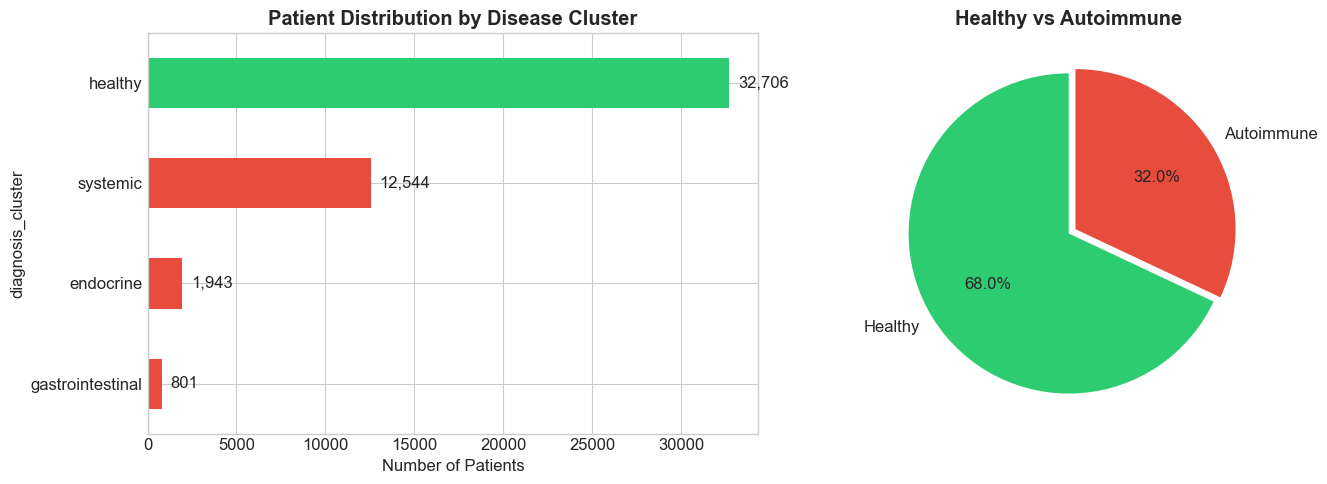


Healthy controls: 32,706 (68.0%)
Autoimmune patients: 15,388 (32.0%)


In [ ]:


# Disease cluster distribution
cluster_counts = df['diagnosis_cluster'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = ['#2ecc71' if c == 'healthy' else '#e74c3c' for c in cluster_counts.index]
cluster_counts.plot(kind='barh', ax=axes[0], color=colors)
axes[0].set_xlabel('Number of Patients')
axes[0].set_title('Patient Distribution by Disease Cluster', fontweight='bold')
axes[0].invert_yaxis()

# Add count labels
for i, v in enumerate(cluster_counts.values):
    axes[0].text(v + 500, i, f'{v:,}', va='center')

# Pie chart - autoimmune vs healthy
autoimmune_count = len(df[df['diagnosis_cluster'] != 'healthy'])
healthy_count = len(df[df['diagnosis_cluster'] == 'healthy'])

axes[1].pie(
    [healthy_count, autoimmune_count],
    labels=['Healthy', 'Autoimmune'],
    colors=['#2ecc71', '#e74c3c'],
    autopct='%1.1f%%',
    startangle=90,
    explode=(0, 0.05)
)
axes[1].set_title('Healthy vs Autoimmune', fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/figures/01_cluster_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nHealthy controls: {healthy_count:,} ({healthy_count/len(df)*100:.1f}%)')
print(f'Autoimmune patients: {autoimmune_count:,} ({autoimmune_count/len(df)*100:.1f}%)')

## 2. Demographics: Who Gets Autoimmune Disease?

Autoimmune diseases disproportionately affect women. Understanding demographic patterns is crucial for fair model development.

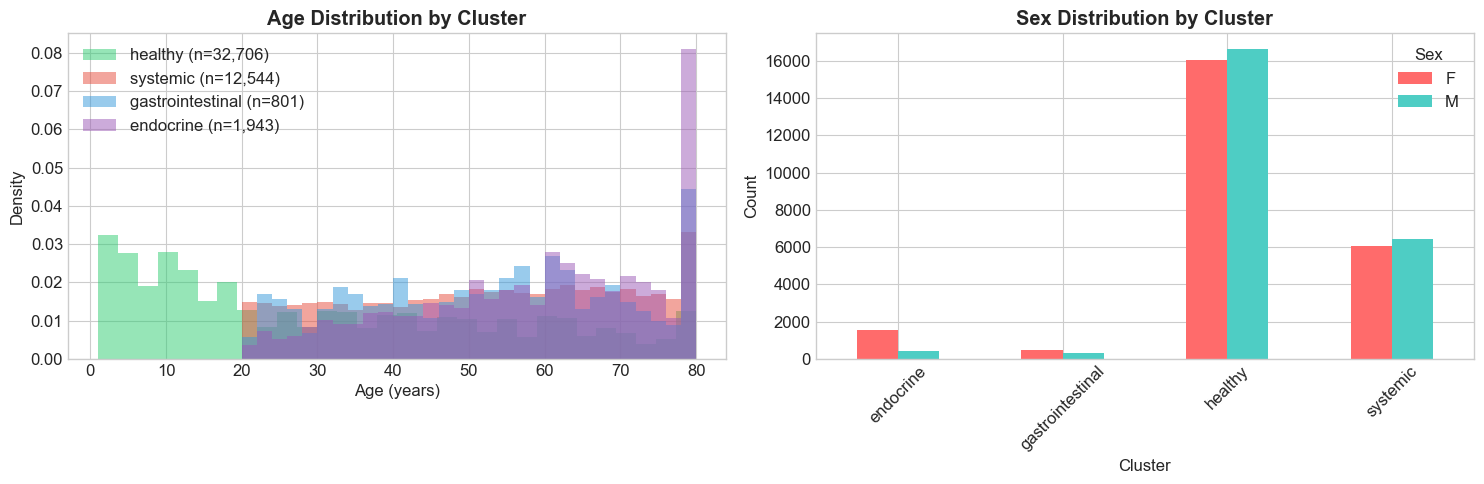

In [7]:
# Demographics by cluster
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Age distribution
priority_clusters = ['healthy', 'systemic', 'gastrointestinal', 'endocrine']
cluster_colors = {'healthy': '#2ecc71', 'systemic': '#e74c3c', 'gastrointestinal': '#3498db', 'endocrine': '#9b59b6'}
df_priority = df[df['diagnosis_cluster'].isin(priority_clusters)]

for cluster in priority_clusters:
    subset = df_priority[df_priority['diagnosis_cluster'] == cluster]['age'].dropna()
    axes[0].hist(subset, bins=30, alpha=0.5, label=f'{cluster} (n={len(subset):,})', 
                 color=cluster_colors.get(cluster), density=True)
axes[0].set_xlabel('Age (years)')
axes[0].set_ylabel('Density')
axes[0].set_title('Age Distribution by Cluster', fontweight='bold')
axes[0].legend()

# Sex distribution
sex_by_cluster = df_priority.groupby(['diagnosis_cluster', 'sex']).size().unstack(fill_value=0)
sex_by_cluster.plot(kind='bar', ax=axes[1], color=['#ff6b6b', '#4ecdc4'])
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Count')
axes[1].set_title('Sex Distribution by Cluster', fontweight='bold')
axes[1].legend(title='Sex')
axes[1].tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.savefig('../outputs/figures/01_demographics.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. The Signal in Lab Values

CBC and inflammatory markers show clear differences between healthy and autoimmune patients - but the overlap is significant, making single-marker diagnosis unreliable.

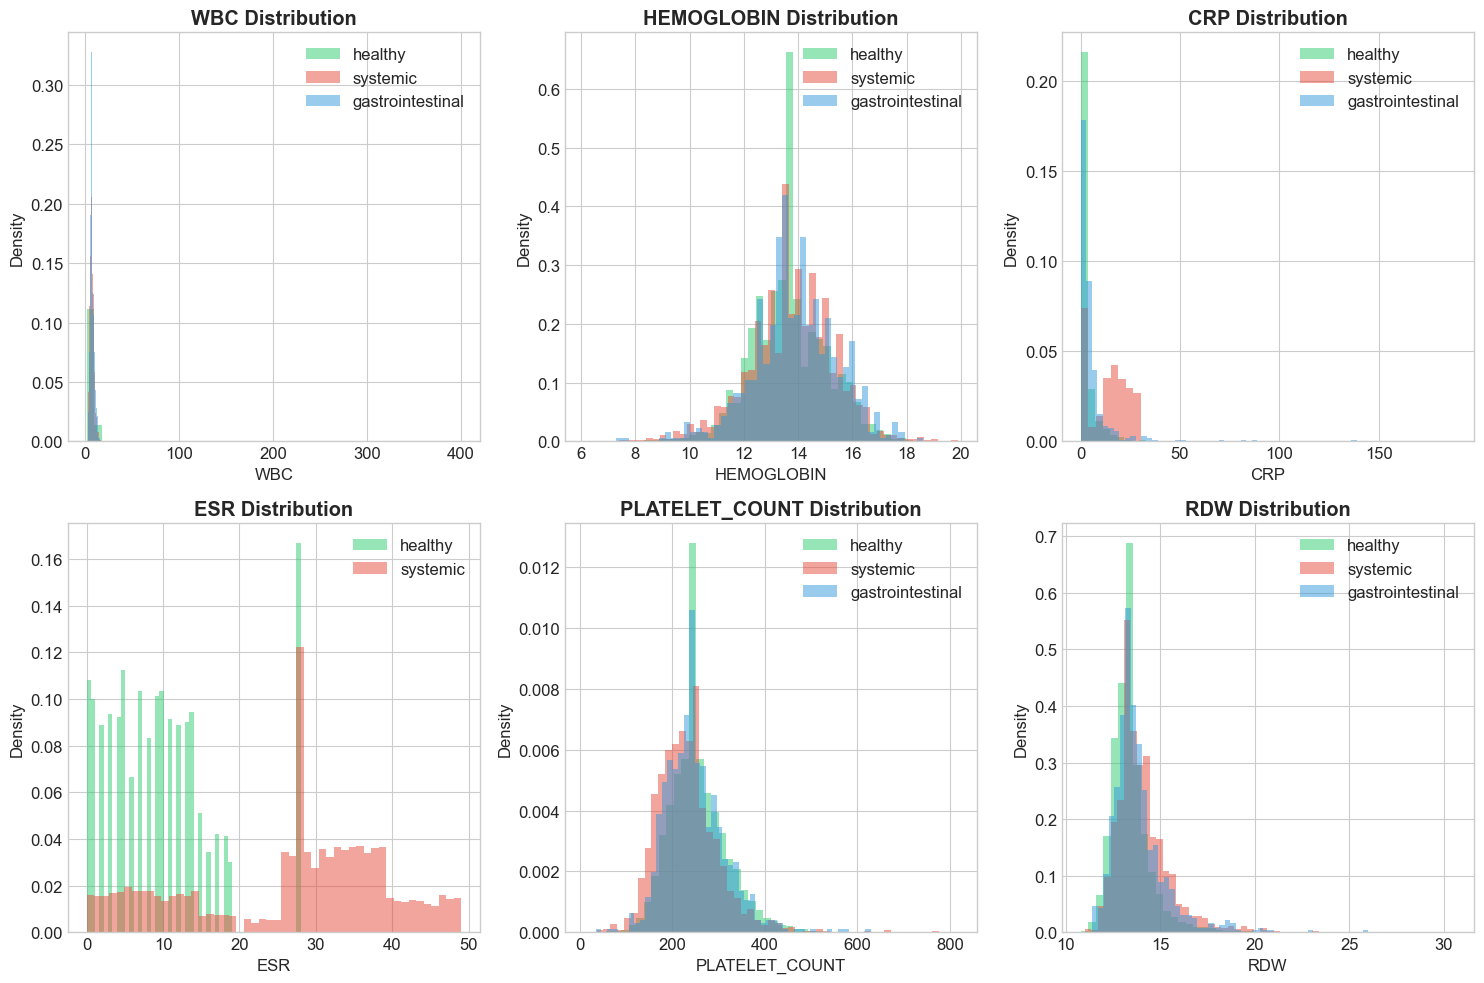

In [8]:
# Key lab markers comparison
lab_markers = ['wbc', 'hemoglobin', 'crp', 'esr', 'platelet_count', 'rdw']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, marker in enumerate(lab_markers):
    for cluster in ['healthy', 'systemic', 'gastrointestinal']:
        subset = df[df['diagnosis_cluster'] == cluster][marker].dropna()
        if len(subset) > 0:
            axes[idx].hist(subset, bins=50, alpha=0.5, label=cluster, 
                          color=cluster_colors.get(cluster), density=True)
    
    axes[idx].set_xlabel(marker.upper())
    axes[idx].set_ylabel('Density')
    axes[idx].set_title(f'{marker.upper()} Distribution', fontweight='bold')
    axes[idx].legend()

plt.tight_layout()
plt.savefig('../outputs/figures/01_lab_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

In [9]:
# Statistical comparison: Healthy vs Autoimmune
df['is_autoimmune'] = df['diagnosis_cluster'] != 'healthy'

print('Lab Marker Comparison: Healthy vs Autoimmune')
print('=' * 70)

stats_data = []
for marker in lab_markers:
    healthy = df[df['is_autoimmune'] == False][marker].dropna()
    autoimmune = df[df['is_autoimmune'] == True][marker].dropna()
    
    stats_data.append({
        'Marker': marker.upper(),
        'Healthy Mean': f'{healthy.mean():.2f}',
        'Healthy Std': f'{healthy.std():.2f}',
        'Autoimmune Mean': f'{autoimmune.mean():.2f}',
        'Autoimmune Std': f'{autoimmune.std():.2f}',
        'Diff': f'{autoimmune.mean() - healthy.mean():+.2f}'
    })

pd.DataFrame(stats_data)

Lab Marker Comparison: Healthy vs Autoimmune


,Marker,Healthy Mean,Healthy Std,Autoimmune Mean,Autoimmune Std,Diff
0,WBC,7.24,3.14,7.42,2.51,+0.17
1,HEMOGLOBIN,13.65,1.40,13.62,1.55,-0.03
2,CRP,3.16,6.57,13.22,10.66,+10.07
3,ESR,9.98,7.65,26.79,13.11,+16.81
4,PLATELET_COUNT,255.69,63.88,238.12,65.44,-17.57
5,RDW,13.43,1.18,13.94,1.48,+0.50


## 4. Z-Scores Reveal Hidden Patterns

Raw lab values vary by age and sex. Z-scores normalize against healthy baselines, revealing true deviations.

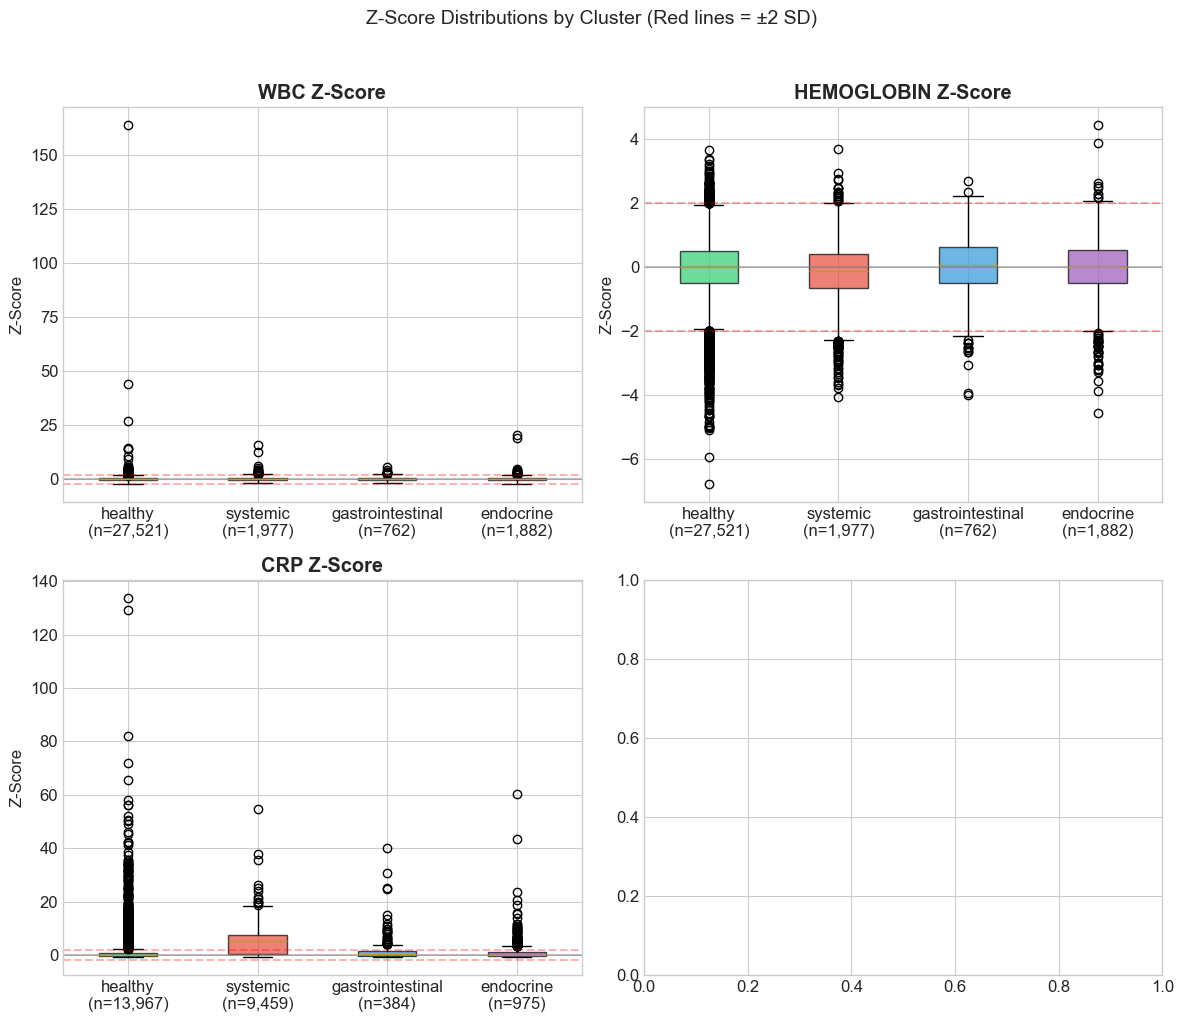

In [10]:
# Z-score distributions by cluster
zscore_cols = ['wbc_zscore', 'hemoglobin_zscore', 'crp_zscore', 'esr_zscore']
zscore_cols = [c for c in zscore_cols if c in df.columns]

if zscore_cols:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for idx, col in enumerate(zscore_cols[:4]):
        data = []
        labels = []
        box_colors = []
        for cluster in priority_clusters:
            subset = df[df['diagnosis_cluster'] == cluster][col].dropna()
            if len(subset) > 0:
                data.append(subset)
                labels.append(f'{cluster}\n(n={len(subset):,})')
                box_colors.append(cluster_colors.get(cluster, 'gray'))
        
        bp = axes[idx].boxplot(data, labels=labels, patch_artist=True)
        for patch, color in zip(bp['boxes'], box_colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        axes[idx].axhline(y=0, color='gray', linestyle='-', alpha=0.5)
        axes[idx].axhline(y=2, color='red', linestyle='--', alpha=0.3)
        axes[idx].axhline(y=-2, color='red', linestyle='--', alpha=0.3)
        axes[idx].set_ylabel('Z-Score')
        axes[idx].set_title(col.replace('_zscore', '').upper() + ' Z-Score', fontweight='bold')

    plt.suptitle('Z-Score Distributions by Cluster (Red lines = ±2 SD)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig('../outputs/figures/01_zscore_boxplots.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print('No z-score columns available')

## 5. Feature Correlations

Understanding how features correlate helps us build better models and avoid multicollinearity.

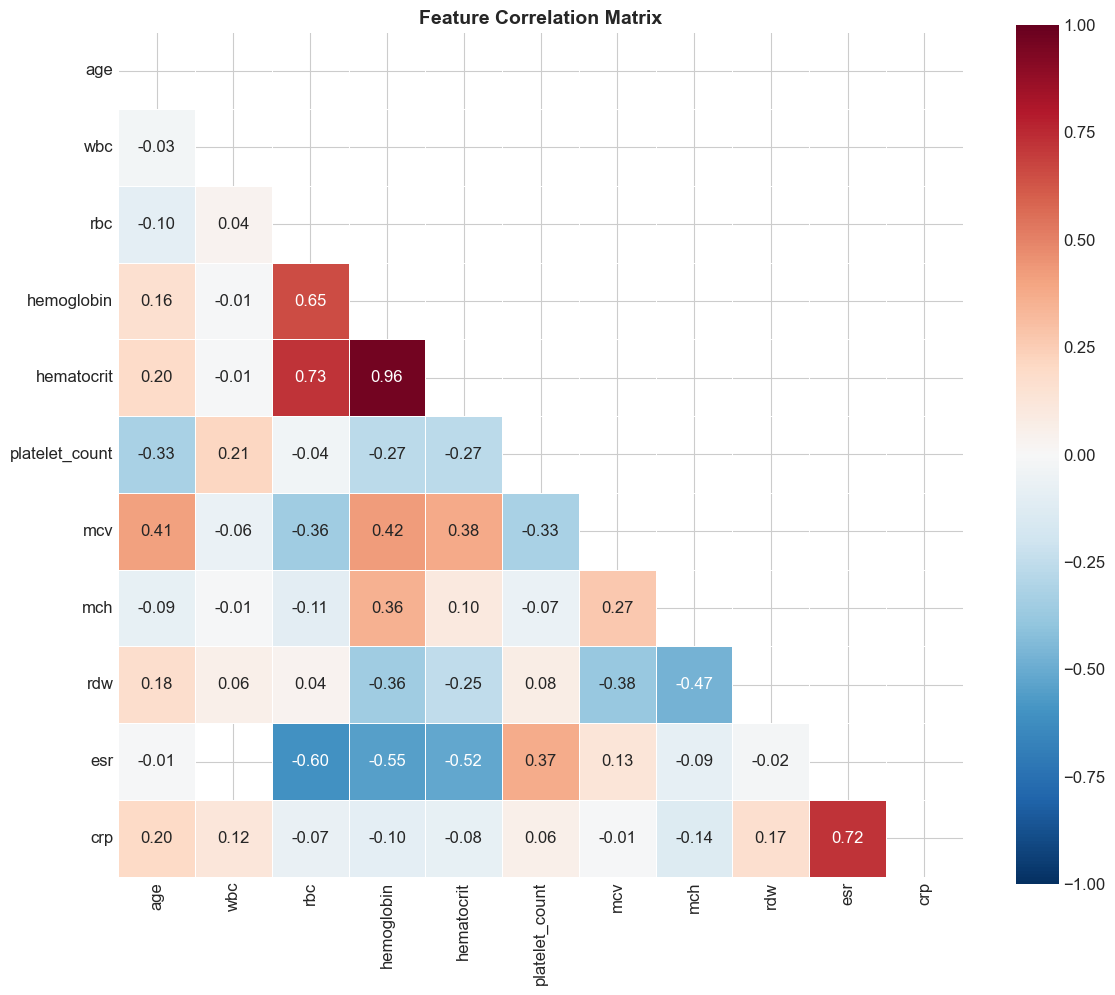

In [11]:
# Correlation heatmap for key features
numeric_features = ['age', 'bmi', 'wbc', 'rbc', 'hemoglobin', 'hematocrit', 
                    'platelet_count', 'mcv', 'mch', 'rdw', 'esr', 'crp']
available_features = [f for f in numeric_features if f in df.columns]

corr_matrix = df[available_features].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/figures/01_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Data Source Distribution

Our data comes from multiple sources, each contributing different types of patients.

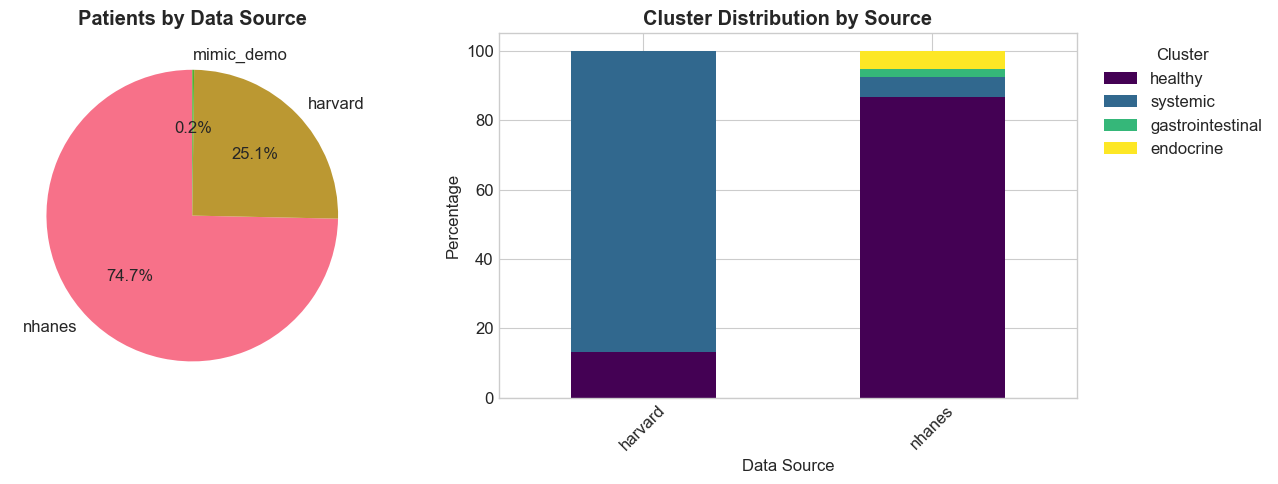


Sample counts by source:
  nhanes: 35,909
  harvard: 12,085
  mimic_demo: 100


In [12]:
# Source breakdown
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart of sources
source_counts = df['source'].value_counts()
axes[0].pie(source_counts.values, labels=source_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Patients by Data Source', fontweight='bold')

# Stacked bar of clusters by source
source_cluster = pd.crosstab(df['source'], df['diagnosis_cluster'], normalize='index') * 100
source_cluster[priority_clusters].plot(kind='bar', stacked=True, ax=axes[1], colormap='viridis')
axes[1].set_xlabel('Data Source')
axes[1].set_ylabel('Percentage')
axes[1].set_title('Cluster Distribution by Source', fontweight='bold')
axes[1].legend(title='Cluster', bbox_to_anchor=(1.02, 1))
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../outputs/figures/01_source_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nSample counts by source:')
for source, count in source_counts.items():
    print(f'  {source}: {count:,}')

## 7. Summary Statistics

In [ ]:
# Summary
print('=' * 70)
print('DATASET SUMMARY')
print('=' * 70)
print(f'Total patients: {len(df):,}')
print(f'Healthy controls: {healthy_count:,} ({healthy_count/len(df)*100:.1f}%)')
print(f'Autoimmune patients: {autoimmune_count:,} ({autoimmune_count/len(df)*100:.1f}%)')
print(f'\nAge range: {df["age"].min():.0f} - {df["age"].max():.0f} years')
print(f'Mean age: {df["age"].mean():.1f} years (SD: {df["age"].std():.1f})')
print(f'\nSex: {(df["sex"]=="F").sum():,} Female ({(df["sex"]=="F").mean()*100:.1f}%), '
      f'{(df["sex"]=="M").sum():,} Male ({(df["sex"]=="M").mean()*100:.1f}%)')
print(f'\nData sources: {df["source"].nunique()}')
print(f'Disease clusters: {df["diagnosis_cluster"].nunique()}')

DATASET SUMMARY
Total patients: 48,094
Healthy controls: 32,706 (68.0%)
Autoimmune patients: 15,388 (32.0%)

Age range: 1 - 91 years
Mean age: 37.8 years (SD: 23.9)

Sex: 24,195 Female (50.3%), 23,899 Male (49.7%)

Data sources: 3
Disease clusters: 4


: 

---

## Key Takeaways for Modeling

1. **Class imbalance**: Need stratified sampling and appropriate metrics (AUC, not accuracy)
2. **Feature overlap**: Single markers insufficient - need multi-feature models
3. **Z-scores are powerful**: Normalize for age/sex effects
4. **Inflammatory markers**: Key predictors for classification
5. **Source effects**: Consider source as a covariate or stratification variable

---

*Next: Comprehensive Analysis (02_comprehensive_analysis.ipynb)*